## Linear.py

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import math

class Linear(nn.Module):

    def __init__(self, num_classes=2):

        super(Linear, self).__init__()

        self.number_class   = num_classes

        _size_image     = 100* 100
        _num1           = 50
        _num2           = 60
        
        self.fc1        = nn.Linear(_size_image, _num1, bias=True)
        self.fc2        = nn.Linear(_num1, _num2, bias=True)
        self.fc3        = nn.Linear(_num2, num_classes, bias=True)

        self.fc_layer1  = nn.Sequential(self.fc1, nn.LeakyReLU(True))
        self.fc_layer2  = nn.Sequential(self.fc2, nn.LeakyReLU(True))
        self.fc_layer3  = nn.Sequential(self.fc3, nn.Sigmoid())
        
        self.classifier = nn.Sequential(self.fc_layer1, self.fc_layer2, self.fc_layer3)
        
        self._initialize_weight()        
        
    def _initialize_weight(self):

        for name, m in self._modules.items():
            if isinstance(m, nn.Linear):
                n = m.in_features
                m.weight.data.uniform_(- 1.0 / math.sqrt(n), 1.0 / math.sqrt(n))

                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


## load data

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import argparse
import sys
import os
import numpy as np
import time
import datetime 
import csv
import configparser
import argparse
import platform
import torchvision.transforms as transforms
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from random import shuffle

# -----------------------------------------------------------------------------
# load dataset
# -----------------------------------------------------------------------------


transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])


#train_data_path = 'relative path of training data set'
train_data_path = './horse-or-human/horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=150, shuffle=True, num_workers=1)  


validation_data_path = './horse-or-human/horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=150, shuffle=True, num_workers=1)


## train dataset + get loss and accuracy

In [ ]:
num_classes = 2

# -----------------------------------------------------------------------------
# load neural network model
# -----------------------------------------------------------------------------

model = Linear(num_classes=num_classes)

# -----------------------------------------------------------------------------
# Set the flag for using cuda
# -----------------------------------------------------------------------------

bCuda = 0

if bCuda:
 
    model.cuda()

# -----------------------------------------------------------------------------
# optimization algorithm
# -----------------------------------------------------------------------------

optimizer   = optim.SGD(model.parameters(), lr=0.015, weight_decay=0.09)
# reduce lr
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, min_lr=0.001, verbose=1, factor = 0.25)
objective   = nn.CrossEntropyLoss()

# -----------------------------------------------------------------------------
# function for training the model
# -----------------------------------------------------------------------------

def train():

    # print('train the model at given epoch')
    accuracy_train = []
    loss_train = []
    correct = 0
    correct_batch = 0

    model.train()
    for idx_batch, (data, target) in enumerate(trainloader):

        if bCuda:
        
            data, target    = data.cuda(), target.cuda()

        data, target    = Variable(data), Variable(target)

        optimizer.zero_grad()

        output  = model(data)
        loss    = objective(output, target)

        loss.backward()
        optimizer.step()

        loss_train_batch    = loss.item() / len(data)
        loss_train.append(loss_train_batch)
        pred        = output.data.max(1)[1]
        correct     += pred.eq(target.data.view_as(pred)).cpu().sum()
        correct_batch = pred.eq(target.data.view_as(pred)).cpu().sum()
        accuracy_train_batch = float(correct_batch) / len(data)
        accuracy_train.append(accuracy_train_batch)
        
    loss_train_mean     = np.mean(loss_train)
    loss_train_std      = np.std(loss_train)
    accuracy_train_mean   = float(correct) / len(trainloader.dataset)  # mean accuracy
    accuracy_train_std  = np.std(accuracy_train)

    return {'loss_train_mean': loss_train_mean, 'loss_train_std': loss_train_std, 'accuracy_train_mean' : accuracy_train_mean, 'accuracy_train_std' : accuracy_train_std}

# -----------------------------------------------------------------------------
# function for testing the model
# -----------------------------------------------------------------------------

def test():

    # print('test the model at given epoch')

    accuracy_test   = []
    loss_test       = 0
    correct         = 0

    model.eval()

    for idx_batch, (data, target) in enumerate(valloader):

        if bCuda:
        
            data, target    = data.cuda(), target.cuda()

        data, target    = Variable(data), Variable(target)

        output  = model(data)
        loss    = objective(output, target)

        loss_test   += loss.item()
        pred        = output.data.max(1)[1]
        correct     += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss_test       = loss_test / len(valloader.dataset)
    accuracy_test   = float(correct) / len(valloader.dataset)

    return {'loss_test': loss_test, 'accuracy_test': accuracy_test}

# -----------------------------------------------------------------------------
# iteration for the epoch
# -----------------------------------------------------------------------------

loss_train_mean, loss_train_std, loss_test, accuracy_test, accuracy_train_mean, accuracy_train_std = [], [], [], [], [], []
loss_temp = 0;

for e in range(3000):
    
    result_train    = train()
    result_test     = test()
    scheduler.step(result_test['loss_test'], e)

    
    loss_train_mean.append(result_train['loss_train_mean'])
    loss_train_std.append(result_train['loss_train_std'])
    loss_test.append(result_test['loss_test'])
    accuracy_test.append(result_test['accuracy_test'])
    accuracy_train_mean.append(result_train['accuracy_train_mean'])
    accuracy_train_std.append(result_train['accuracy_train_std'])
    
    print(f"[epoch {e}] loss: (training) {loss_train_mean[-1]} , (testing) {loss_test[-1]} , accuracy: (training) {result_train['accuracy_train_mean']} ,    (testing) {accuracy_test[-1]}")
    
    if(abs(loss_temp - loss_train_mean[-1]) < 10e-7):
        break;
    loss_temp = loss_train_mean[-1]


[epoch 0] loss: (training) 0.004722740877689294 , (testing) 0.005386430071666837 , accuracy: (training) 0.5209347614410905 ,    (testing) 0.5
[epoch 1] loss: (training) 0.004694782720776054 , (testing) 0.005367470672354102 , accuracy: (training) 0.5141187925998053 ,    (testing) 0.5
[epoch 2] loss: (training) 0.004676429904888397 , (testing) 0.005352270090952516 , accuracy: (training) 0.5131450827653359 ,    (testing) 0.5
[epoch 3] loss: (training) 0.0046632249966783385 , (testing) 0.0052966829389333725 , accuracy: (training) 0.5131450827653359 ,    (testing) 0.5
[epoch 4] loss: (training) 0.004648948370583459 , (testing) 0.005292803514748812 , accuracy: (training) 0.5228821811100293 ,    (testing) 0.5
[epoch 5] loss: (training) 0.0046345620129409695 , (testing) 0.005253681447356939 , accuracy: (training) 0.5384615384615384 ,    (testing) 0.5
[epoch 6] loss: (training) 0.004624562042234183 , (testing) 0.005232499213889241 , accuracy: (training) 0.5404089581304771 ,    (testing) 0.50390

## plot accuracy and loss

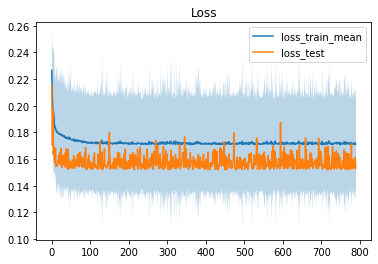

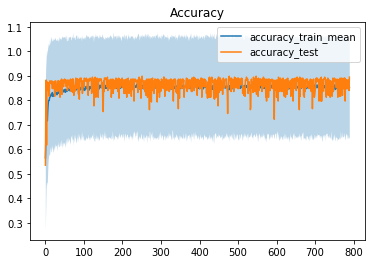

In [9]:
import matplotlib.pyplot as plt

plt.title("Loss")
plt.plot(loss_train_mean)
plt.plot(loss_test)
plt.fill_between(np.arange(1,len(loss_train_mean)+1), np.array(loss_train_mean) - np.array(loss_train_std),np.array(loss_train_mean) + np.array(loss_train_std), alpha = 0.3)
plt.legend(['loss_train_mean','loss_test'])
plt.show()


plt.title("Accuracy")
plt.plot(accuracy_train_mean)
plt.plot(accuracy_test)
plt.fill_between(np.arange(1,len(accuracy_train_mean)+1), np.array(accuracy_train_mean) - np.array(accuracy_train_std),np.array(accuracy_train_mean) + np.array(accuracy_train_std), alpha = 0.3)
plt.legend(['accuracy_train_mean','accuracy_test'])
plt.show()


## accuracy and loss table

In [10]:
print("  dataset     |           loss           |          accuracy         |")
print("----------------------------------------------------------------------")
print("   train      |       %.10f       |       %.10f        |"%(loss_train_mean[-1],accuracy_train_mean[-1]))
print("----------------------------------------------------------------------")
print("   test       |       %.10f       |       %.10f        |"%(loss_test[-1],accuracy_test[-1]))
print("----------------------------------------------------------------------")

  dataset     |           loss           |          accuracy         |
----------------------------------------------------------------------
   train      |       0.1712107689       |       0.8529698150        |
----------------------------------------------------------------------
   test       |       0.1528018866       |       0.8945312500        |
----------------------------------------------------------------------
